In [7]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import tensorflow as tf
# # from cnn_code import le, scaler
# %run -i Beacon_CNN_Model.ipynb
# from Beacon_CNN_Model import le, scaler
import plotly.graph_objs as go
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow.keras.backend as K
K.clear_session()

ModuleNotFoundError: No module named 'Tkinter'

In [1]:
def choose_file():
    # Open a file dialog to choose the test data CSV file
    file_path = filedialog.askopenfilename()
    test_data_entry.delete(0, tk.END)
    test_data_entry.insert(0, file_path)

In [3]:
def predict():
    # Load the saved model
    #model = tf.keras.models.load_model(r'C:\Users\winst\Desktop\my_model.h5')
    #model = tf.keras.models.load_model(r'C:\Users\winst\Desktop\rnn_model.h5')
    #model = tf.keras.models.load_model(r'C:\Users\winst\Desktop\feedforward_model.h5')    
    model = joblib.load('Random_forest_model.pkl') # Load the random forest model
    #model = joblib.load('xg_boost.pkl') # Load the xg_boost model

    
    # Load the CSV file for prediction
    test_data_file = test_data_entry.get()
    test_data = pd.read_csv(test_data_file)

    # Create a LabelEncoder object and fit it to the 'deviceSerialNumber' column
    le = LabelEncoder()
    le.fit(test_data['deviceSerialNumber'])
    # Convert deviceSerialNumber to numerical values
    test_data['deviceSerialNumber'] = le.transform(test_data['deviceSerialNumber'])

    # Scale the data
    X_test = test_data[['deviceSerialNumber', 'beaconId', 'rssiCh37', 'rssiCh38', 'rssiCh39','seqNo']]
    # Create a StandardScaler object and fit it to the test data
    scaler = StandardScaler()
    scaler.fit(X_test)
    X_test = scaler.transform(X_test)
    #X_test = X_test.reshape(X_test.shape[0], 5, 1, 1) # for cnn model
    #X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1])) # for rnn model
    #X_test = X_test.reshape(X_test.shape[0], -1) # for feedforward model

    
    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform the deviceSerialNumber back to its original name
    test_data['deviceSerialNumber'] = le.inverse_transform(test_data['deviceSerialNumber'])

    # assign predicted values to each row in the test data
    test_data['Block'] = [int(val) for val in y_pred]

#     # Add the predicted block to the test_data DataFrame
#     test_data['Block'] = y_pred

    # Save the results to a new CSV file
    test_data.to_csv('predicted_data.csv', index=False)

    # Load the predicted data
    predicted_data = pd.read_csv('predicted_data.csv')

    # Create a scatter plot of beacon ID vs block number
    plt.scatter(predicted_data['beaconId'], predicted_data['Block'], c=predicted_data['beaconId'])
    plt.xlabel('Beacon ID')
    plt.ylabel('Block Number')
    plt.show()

In [4]:
def plot_3d():
    # Create a 3D scatter plot of beacon ID vs block number
    predicted_data = pd.read_csv('predicted_data.csv')
    beacon_ids = predicted_data['beaconId'].unique()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for beacon_id in beacon_ids:
        mask = predicted_data['beaconId'] == beacon_id
        ax.scatter(predicted_data.loc[mask, 'beaconId'],
                   predicted_data.loc[mask, 'Block'],
                   predicted_data.loc[mask].index,
                   label=f'Beacon {beacon_id}')
    ax.set_xlabel('Beacon ID')
    ax.set_ylabel('Block Number')
    ax.set_zlabel('Index')
    ax.legend()
    plt.show()


In [5]:
def heat_map():
    #heat map
    
    # Load data from CSV file
    data = pd.read_csv('predicted_data.csv')

    # Create a pivot table with Block as rows, BeaconId as columns, and count of values as values
    heatmap_data = pd.pivot_table(data, values='seqNo', index=['Block'], columns=['beaconId'], aggfunc=len, fill_value=0)

    # Create heatmap using Seaborn library
    sns.heatmap(heatmap_data, cmap='YlGnBu')

    # Show plot
    plt.show()

In [6]:
def heat_map_3d():
    
    data = pd.read_csv('predicted_data.csv')

    # Create pivot table with Block as rows, BeaconId as columns, and count of values as values
    heatmap_data = pd.pivot_table(data, values='seqNo', index=['Block'], columns=['beaconId'],
                                      aggfunc=len, fill_value=0)

    # Define x, y, and z coordinates
    x = heatmap_data.columns
    y = heatmap_data.index
    z = heatmap_data.values

    # Create 3D surface plote
    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y, colorscale='YlGnBu')])
    fig.update_layout(scene=dict(xaxis_title='Beacon ID', yaxis_title='Block Number', zaxis_title='Count'))
    fig.show()

#   # Save plot as an image
#   fig.write_image('static/prediction.png')

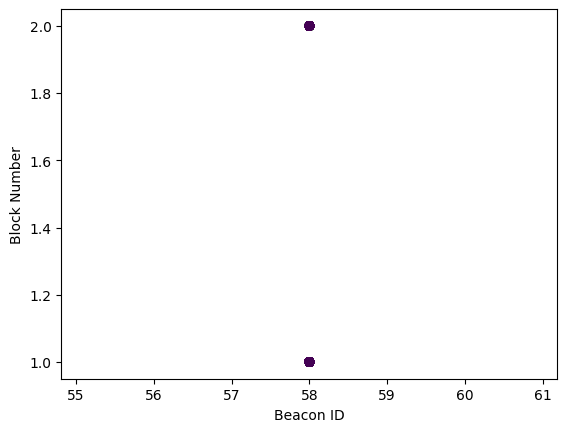

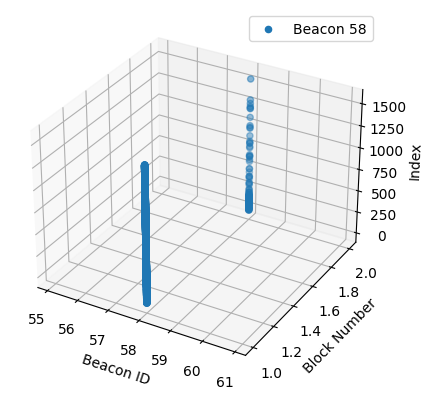

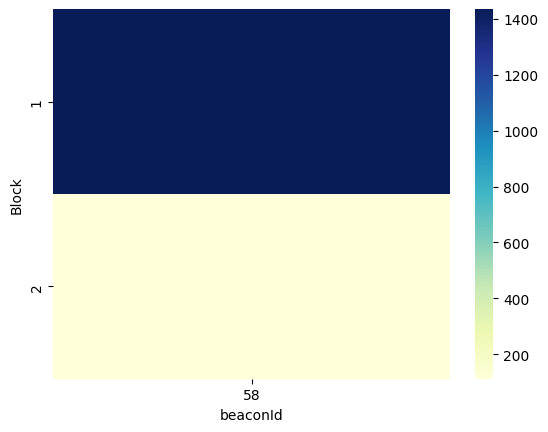

In [7]:
# Create the GUI
root = tk.Tk()
root.title('Predict Block Number')
root.geometry('500x230')

# Create a label and entry for the test data file path
test_data_label = tk.Label(root, text='Test Data:')
test_data_label.pack(side=tk.LEFT)
test_data_entry = tk.Entry(root, width=30)
test_data_entry.pack(side=tk.LEFT)

test_data_button = tk.Button(root, text='Choose File', command=choose_file)
test_data_button.pack(side=tk.LEFT)

# Create a button to run the prediction
predict_button = tk.Button(root, text='Predict', command=predict)
predict_button.pack(padx=10, pady=10)

# Create a button to plot the 3D scatter plot
plot_3d_button = tk.Button(root, text='Plot 3D', command=plot_3d)
plot_3d_button.pack(padx=10, pady=10)

# Create a button to plot the heat map plot
plot_heat_map = tk.Button(root, text='Plot Heat Map', command=heat_map)
plot_heat_map.pack(padx=10, pady=10)

# Create a button to plot the heat map plot
plot_3d_heatmap = tk.Button(root, text='Plot 3D-Heat Map', command=heat_map_3d)

plot_3d_heatmap.pack(padx=10, pady=10)
root.mainloop()